Tuning XGBoost Model...
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


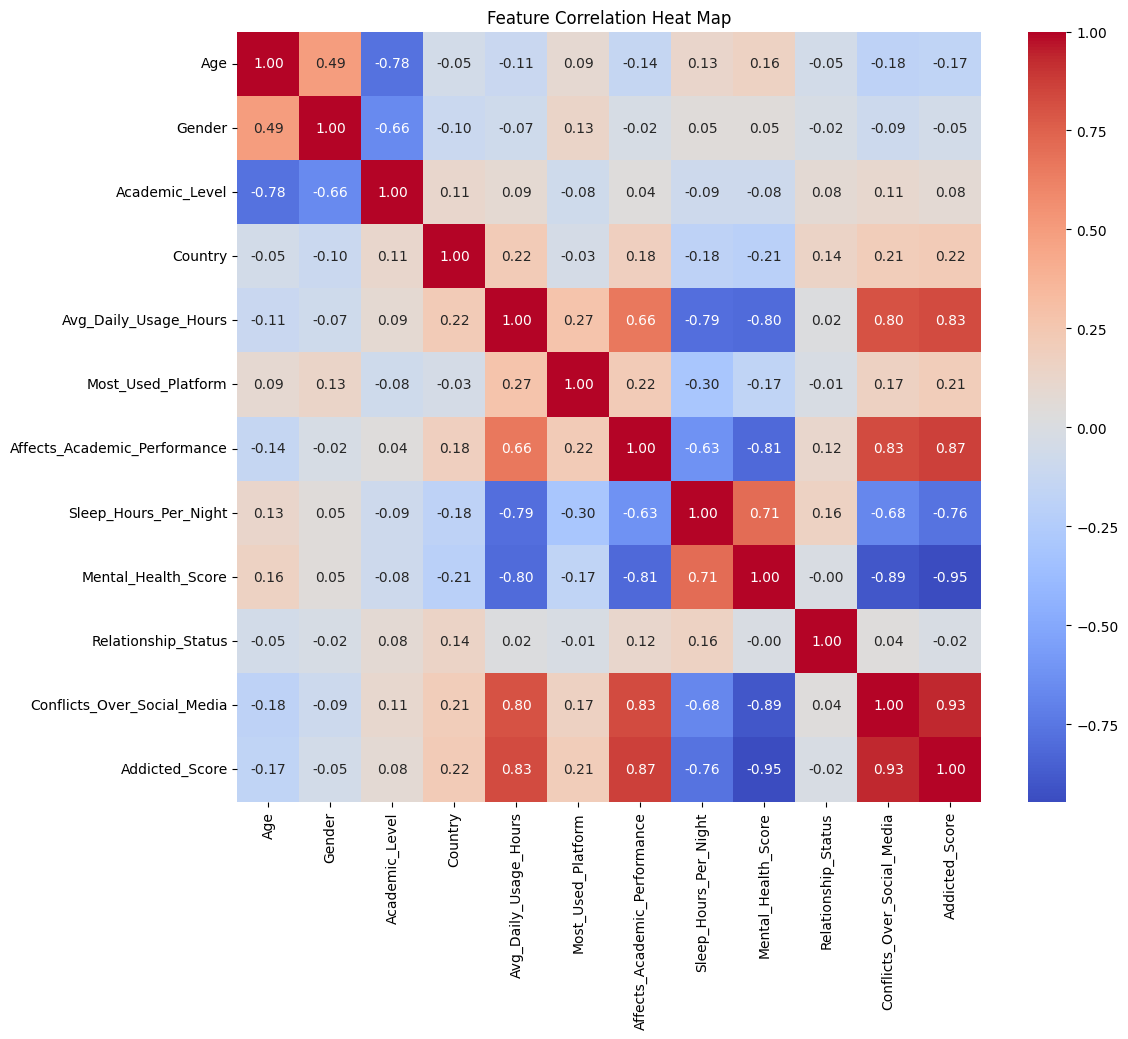

/tmp/ipython-input-4082825482.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_values, palette='viridis')


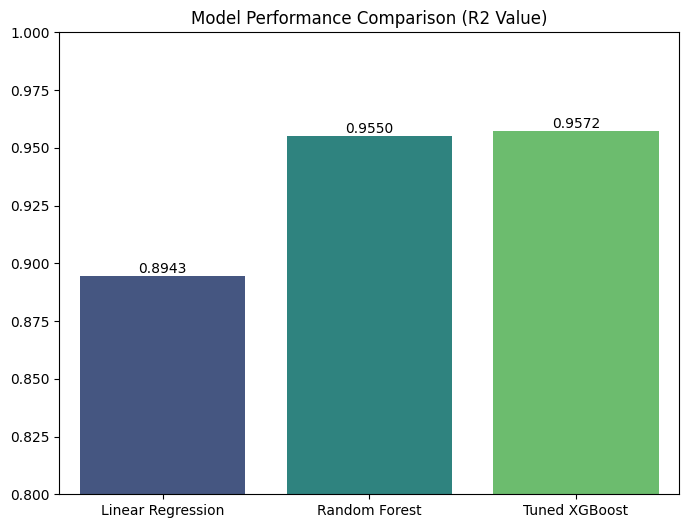

/tmp/ipython-input-4082825482.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='magma')


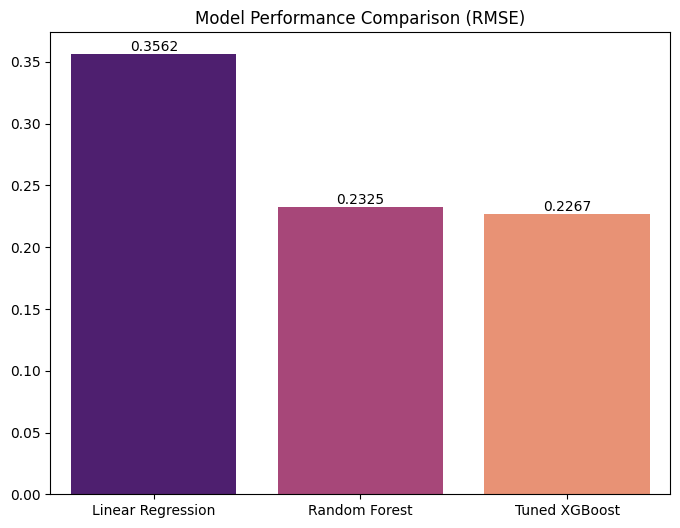

<Figure size 1000x600 with 0 Axes>

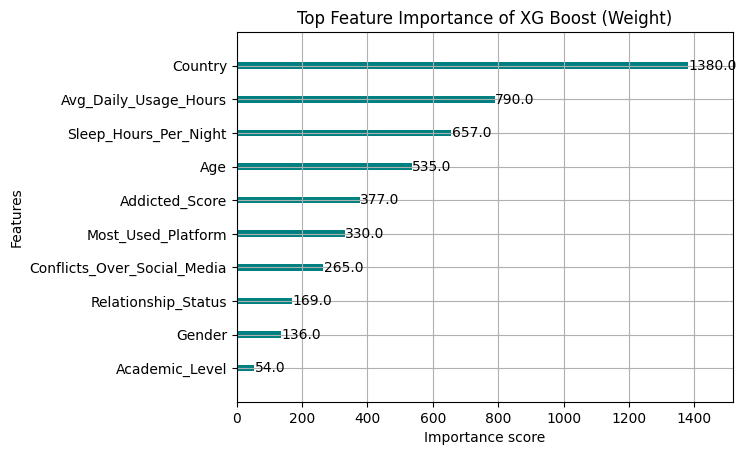

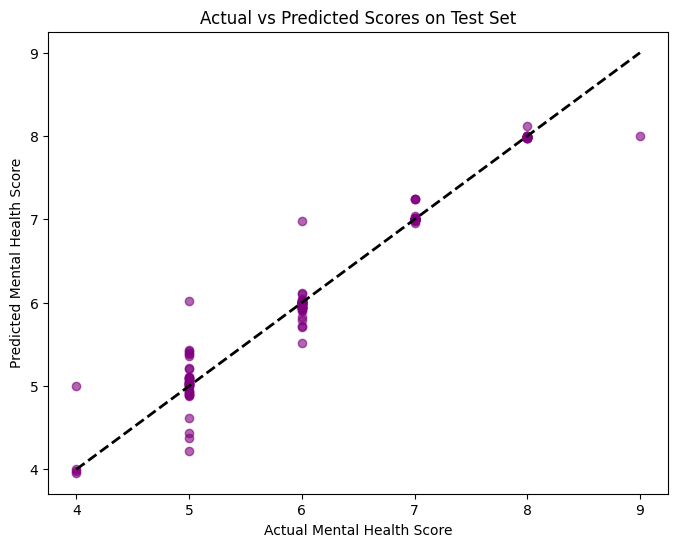

/tmp/ipython-input-4082825482.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.index, y=target_corr.values, palette=colors)


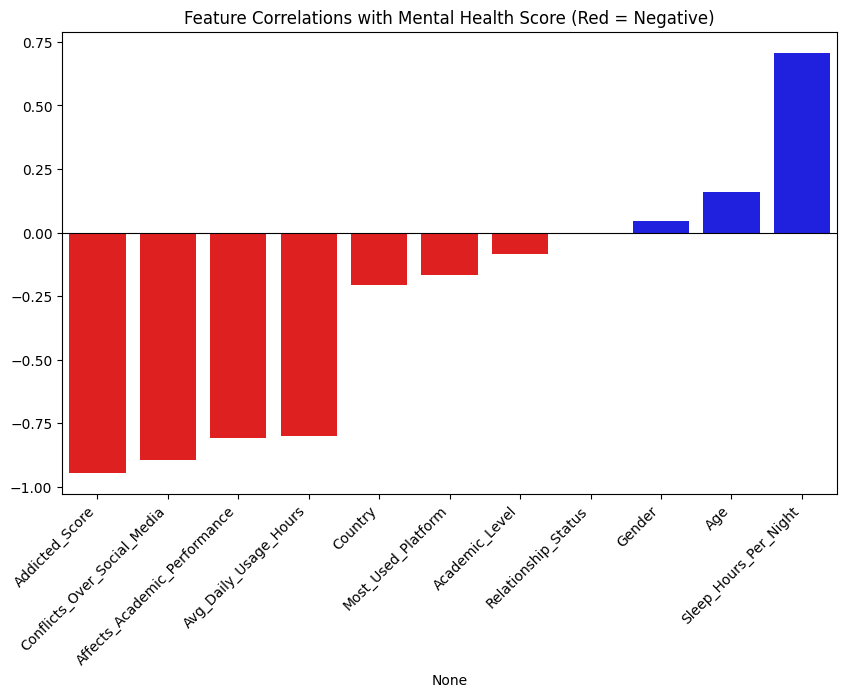

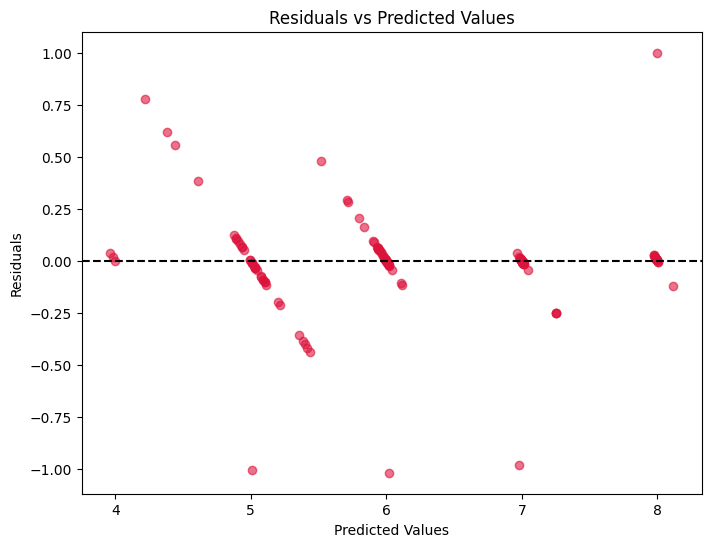

<Figure size 1000x600 with 0 Axes>

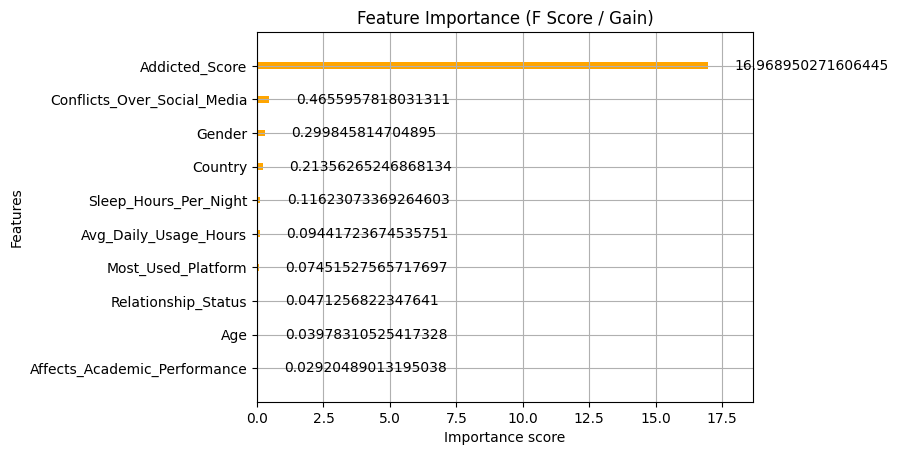

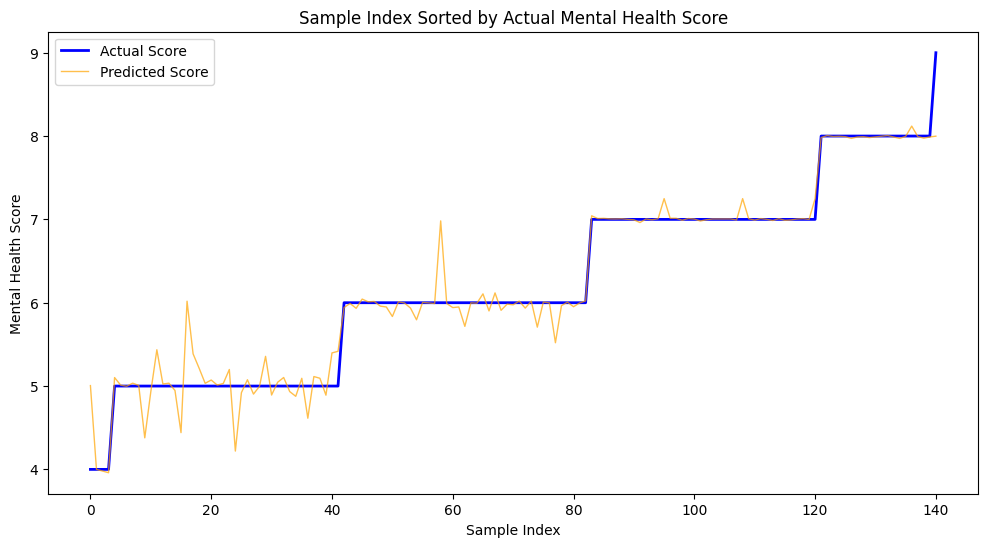

In [2]:
# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
!pip install xgboost  # Ensure XGBoost is installed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (Upload 'Students Social Media Addiction.csv' to Colab first!)
df = pd.read_csv('Students Social Media Addiction.csv')

# ==========================================
# 2. PREPROCESSING
# ==========================================
# Encode Categorical Variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform',
                    'Affects_Academic_Performance', 'Relationship_Status']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Define X and y (Target: Mental Health Score)
X = df.drop(['Student_ID', 'Mental_Health_Score'], axis=1)
y = df['Mental_Health_Score']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 3. MODEL TRAINING & TUNING
# ==========================================
# A. Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

# B. Random Forest (Comparison)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# C. Tuned XGBoost Model
print("Tuning XGBoost Model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Select Best Model
best_xgb = grid_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)
print(f"Best XGBoost Params: {grid_search.best_params_}")

# ==========================================
# 4. GENERATING REQUESTED GRAPHS
# ==========================================

# Graph 1: Feature Correlation Heat Map
plt.figure(figsize=(12, 10))
corr_matrix = df.drop('Student_ID', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heat Map")
plt.show()

# Metrics Calculation
models = ['Linear Regression', 'Random Forest', 'Tuned XGBoost']
r2_values = [r2_score(y_test, lr_pred), r2_score(y_test, rf_pred), r2_score(y_test, xgb_pred)]
rmse_values = [np.sqrt(mean_squared_error(y_test, lr_pred)),
               np.sqrt(mean_squared_error(y_test, rf_pred)),
               np.sqrt(mean_squared_error(y_test, xgb_pred))]

# Graph 2: Model Performance Comparison (R2 Value)
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=r2_values, palette='viridis')
plt.title("Model Performance Comparison (R2 Value)")
plt.ylim(0.8, 1.0) # Zoom to show differences
for i, v in enumerate(r2_values):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

# Graph 3: Model Performance Comparison (RMSE)
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=rmse_values, palette='magma')
plt.title("Model Performance Comparison (RMSE)")
for i, v in enumerate(rmse_values):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

# Graph 5: Top Feature Importance of XGBoost
plt.figure(figsize=(10, 6))
# Get importance type 'weight' or 'gain'
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10, color='teal')
plt.title("Top Feature Importance of XG Boost (Weight)")
plt.show()

# Graph 6 & 9: Actual vs Predicted (Test Set)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_pred, alpha=0.6, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Mental Health Score")
plt.ylabel("Predicted Mental Health Score")
plt.title("Actual vs Predicted Scores on Test Set")
plt.show()

# Graph 7: Negative Correlation (Visualizing correlations with Target)
plt.figure(figsize=(10, 6))
target_corr = corr_matrix['Mental_Health_Score'].drop('Mental_Health_Score').sort_values()
# Color code: Red for negative, Blue for positive
colors = ['red' if x < 0 else 'blue' for x in target_corr.values]
sns.barplot(x=target_corr.index, y=target_corr.values, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Feature Correlations with Mental Health Score (Red = Negative)")
plt.show()

# Graph 8: Residuals vs Predicted Values
residuals = y_test - xgb_pred
plt.figure(figsize=(8, 6))
plt.scatter(xgb_pred, residuals, alpha=0.6, color='crimson')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# Graph 10: Feature Importance F Score (Using 'gain' metric often used for F-score equivalent)
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb, importance_type='gain', max_num_features=10, color='orange')
plt.title("Feature Importance (F Score / Gain)")
plt.show()

# Graph 11: Sample Index Sorted by Actual Price (Score)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})
comparison_df = comparison_df.sort_values(by='Actual').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'], label='Actual Score', color='blue', linewidth=2)
plt.plot(comparison_df['Predicted'], label='Predicted Score', color='orange', alpha=0.7, linewidth=1)
plt.legend()
plt.title("Sample Index Sorted by Actual Mental Health Score")
plt.xlabel("Sample Index")
plt.ylabel("Mental Health Score")
plt.show()